In [29]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from tqdm import tqdm
import shutil
import glob
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf

In [13]:
os.chdir("/rds/general/user/ft824/home/ML_BreakHis/data")

In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#download pretrained weights 
#model = ResNet50(weights='imagenet', include_top=False)


In [15]:
# get pretrained weight without last layer
resnet_weights_path = '/rds/general/user/ft824/home/.keras/models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

CHANNELS = 3
IMAGE_RESIZE = 224
NUM_CLASSES = 2 # change this to match your number of output classes
DENSE_LAYER_ACTIVATION = 'sigmoid'  # use 'softmax' for categorical classification
RESNET50_POOLING_AVERAGE = 'avg'  
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

#BATCH_SIZE sould be FACTOR of no of img in train and validation
BATCH_SIZE_TRAINING = 32
BATCH_SIZE_VALIDATION = 16

In [16]:
# Build the model
model = Sequential()

# Add pre-trained ResNet50 as the base (without the top classifier layer)
model.add(ResNet50(
    include_top=False,
    pooling=RESNET50_POOLING_AVERAGE,
    weights=resnet_weights_path,
    input_shape=(224, 224, 3)  # or your image size
))

# Freeze the base model, not to train first layer
model.layers[0].trainable = False

# Add output layer for classification
model.add(Dense(NUM_CLASSES, activation=DENSE_LAYER_ACTIVATION))

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
from tensorflow.keras.optimizers import SGD

# Define optimizer
sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model
model.compile(optimizer=sgd, loss=OBJECTIVE_FUNCTION, metrics=LOSS_METRICS)


/rds/general/user/ft824/home/anaconda3/envs/breakhis/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# Load your CSV files
train_df = pd.read_csv('../data/augmented_train_dataset.csv')
#augment_train = pd.read_csv('../data/augmented_dataset.csv')
#train_df = pd.concat([train_df, augment_train], axis=0, ignore_index=True)

test_df = pd.read_csv('../data/new_test.csv')

image_size = 224  # for ResNet50


# Define the ImageDataGenerator with preprocessing
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


# Training generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',    # column with image file paths
    y_col='label',       # column with image labels
    target_size=(image_size, image_size),  # resizing to match ResNet50 input size
    batch_size=32,
    class_mode='categorical' # multi-class classification
)

# Test generator
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',    # column with image file paths
    y_col='label',       # column with image labels
    target_size=(image_size, image_size),  # resizing to match ResNet50 input size
    batch_size=16,
    class_mode='categorical'
)

TypeError: If class_mode="categorical", y_col="label" column values must be type string, list or tuple.

In [23]:
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(test_generator))

(32, 182, 16, 93)

In [24]:
##check for missing files
print(train_df['filepath'].head())
missing = train_df[~train_df['filepath'].apply(os.path.exists)]
print(f"Missing files: {len(missing)}")
print(missing.head())


0    ../train_aug/original_2621.png
1    ../train_aug/original_4985.png
2    ../train_aug/original_3990.png
3    ../train_aug/original_2934.png
4    ../train_aug/original_4068.png
Name: filepath, dtype: object
Missing files: 0
Empty DataFrame
Columns: [filepath, label, magnification, tumor_subtype]
Index: []


In [33]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '../working/best.weights.h5', monitor = 'val_loss', save_best_only = True, save_weights_only=True)

In [34]:
fit_history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=test_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)
model.load_weights("../working/best.weights.h5")

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 256s 27s/step - accuracy: 0.8028 - loss: 0.7943 - val_accuracy: 0.7937 - val_loss: 0.7476
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 323s 34s/step - accuracy: 0.8280 - loss: 0.5253 - val_accuracy: 0.8750 - val_loss: 0.4148
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 341s 35s/step - accuracy: 0.8854 - loss: 0.4089 - val_accuracy: 0.7812 - val_loss: 0.7345
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 334s 35s/step - accuracy: 0.8247 - loss: 0.6729 - val_accuracy: 0.8438 - val_loss: 0.6105
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 314s 33s/step - accuracy: 0.9043 - loss: 0.3639 - val_accuracy: 0.8562 - val_loss: 0.6322


In [30]:
print(tf.__version__)


2.18.0


In [6]:
# Check accuracy function
def check_accuracy(output,labels):
    _,predpos=output.max(1)
    num_samples=len(labels)
    num_correct=(predpos==labels).sum()
    return (num_correct/num_samples)*100


In [ ]:
def save_checkpoint(state,filename='clahe.pth.tar'):
    print('Saving weights-->')
    torch.save(state,filename)

In [ ]:
def load_checkpoint(filename):
    print('Loading weights-->')
    model.load_state_dict(checkpoint['state_dict'])
    optim.load_state_dict(checkpoint['optimizer'])

In [ ]:
# Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
shuffle_dataset = True
random_seed= 42
num_workers=2
learning_rate=0.001
print(device)
num_epochs=25
load_model=False

In [ ]:
# Create resnet model, with respecitve transform
model = models.resnet50(pretrained=False)
model.fc=nn.Sequential(nn.Linear(2048,1024),
                      nn.LeakyReLU(),
                      nn.Linear(1024,512),
                      nn.LeakyReLU(),
                      nn.Linear(512,2))
print(model)

In [ ]:
# Loss and Optimizer
criterion=nn.CrossEntropyLoss()
optim=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
if load_model:
    load_checkpoint(torch.load('weights.pth.tar'))

In [ ]:
##Load data
#train, validation, test
train_loader = DataLoader(train_set, batch_size=batch_size,num_workers=num_workers, shuffle=True)
validation_loader = DataLoader(valid_set, batch_size=batch_size,num_workers=num_workers,shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size,num_workers=num_workers,shuffle=True)

In [ ]:

# Put model on cuda 
model.to(device)
# Put the model on train mode
model.train()
print()

In [ ]:
i,y=next(iter(train_loader))
i=i.to(device)
y=y.to(device)
y_pred=model(i)
print(y_pred.shape)

In [ ]:
# Training loop for the model
min_loss=None
for epoch in range(num_epochs):
    losses=[]
    accuracies=[]
    loop= tqdm(enumerate(train_loader),total=len(train_loader),leave=False)
    for batch_idx, (data,labels) in loop:
        # Put data on cuda
        data=data.to(device)
        labels=labels.to(device).long()
        
        # Forward pass
        output=model(data)
        
        # Find out loss
        loss=criterion(output,labels)
        accuracy=check_accuracy(output,labels)
        losses.append(loss.detach().item())
        accuracies.append(accuracy.detach().item())
        
        optim.zero_grad()
        
        # Back prop
        loss.backward()
        
        # Step
        optim.step()
        
        # Update TQDM progress bar
        loop.set_description(f"Epoch [{epoch}/{num_epochs}] ")
        loop.set_postfix(loss=loss.detach().item(),accuracy=accuracy.detach().item())
        
    moving_loss=sum(losses)/len(losses)
    moving_accuracy=sum(accuracies)/len(accuracies)
    checkpoint={'state_dict': model.state_dict(),'optimizer': optim.state_dict()}
    # Save check point
    if min_loss==None:
        min_loss=moving_loss
        save_checkpoint(checkpoint)
    elif moving_loss<min_loss:
        min_loss=moving_loss
        save_checkpoint(checkpoint)
    print('Epoch {0} : Loss = {1} , Accuracy={2}'.format(epoch,moving_loss,moving_accuracy))

In [ ]:
# Validation accuracy
correct=0
samples=0
for data,labels in validation_loader:
    data=data.to(device)
    labels=labels.to(device)
    # Forward pass
    y_pred=model(data)
    # Accuracy over entire dataset
    _,predpos=y_pred.max(1)
    samples+=len(labels)
    correct+=(predpos==labels).sum().detach().item()
print('Validation accuracy : ',(correct/samples)*100)


In [ ]:

# Test accuracy
correct=0
samples=0
for data,labels in test_loader:
    data=data.to(device)
    labels=labels.to(device)
    # Forward pass
    y_pred=model(data)
    # Accuracy over entire dataset
    _,predpos=y_pred.max(1)
    samples+=len(labels)
    correct+=(predpos==labels).sum().detach().item()
print('Test accuracy : ',(correct/samples)*100)

Prediction


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model


In [25]:

#Define generator for the unseen/test data
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_df = pd.read_csv("../data/augmented_train_dataset.csv")
train_df['filepath'] = train_df['filepath'].str.replace(r"^\.\./", "../data/", regex=True)

#convert labels to string
train_df['label'] = train_df['label'].astype(str)

holdout_data = pd.read_csv("../data/new_holdout.csv")

image_size = 224  # for ResNet50

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',    # column with image file paths
    y_col='label',       # column with image labels
    target_size=(image_size, image_size),  # resizing to match ResNet50 input size
    batch_size=32,
    class_mode='categorical' # multi-class classification
)

unseen_generator = datagen.flow_from_dataframe(
    dataframe=holdout_data,           
    x_col='filepath',
    y_col=None,                 #labels for unseen data
    target_size=(224, 224),        # <- match input size to model
    class_mode=None,               # <- no class_mode
    batch_size=32,
    shuffle=False                  # <- don't shuffle, to keep predictions in order
)


Found 5820 validated image filenames belonging to 2 classes.
Found 1978 validated image filenames.


In [26]:
#load trained resnet model
model = load_model("resnet50_best_model.h5")
predictions = model.predict(unseen_generator)

### get labels
predicted_classes = np.argmax(predictions, axis=1)  # for categorical output

class_indices = train_generator.class_indices
label_map = {0: "benign", 1: "malignant"}

predicted_labels = [label_map[i] for i in predicted_classes]

print(train_generator.class_indices)


/rds/general/user/ft824/home/anaconda3/envs/breakhis/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 1812s 29s/step
{'0': 0, '1': 1}


In [27]:

##evaluate accuracy

loss, accuracy = model.evaluate(unseen_generator)
with open("evaluation.txt", "w") as f:
    f.write(f"Loss: {loss}\n")
    f.write(f"Accuracy: {accuracy}\n")


ValueError: None values not supported.

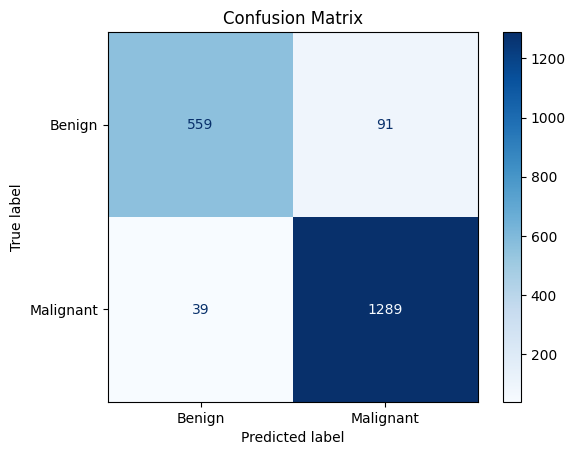

In [28]:

###confusion matrix
true_labels = holdout_data['label'].astype(int).values

cm = confusion_matrix(true_labels, predicted_classes)

#
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [33]:
acc = round(accuracy_score(true_labels, predicted_classes), 3)
f1 = round(f1_score(true_labels, predicted_classes),3)
precision = round(precision_score(true_labels, predicted_classes),3)
recall = round(recall_score(true_labels, predicted_classes),3)

print(acc)
print(f1)
print(precision)
print(recall)

0.934
0.952
0.934
0.971
